In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [12]:
def read_data(file, m):
    n = int(file.readline().strip())
    X = np.zeros((n, m + 1))
    y = np.zeros(n)
    for i in range(n):
        row = list(map(float, file.readline().strip().split()))
        for j in range(m):
            X[i, j] = row[j]
        X[i, m] = 1
        y[i] = row[m]
    return X, y


def read_dataset(file):
    m = int(file.readline().strip()) # |x[i]|
    X_train, y_train = read_data(file, m)
    X_test, y_test = read_data(file, m)
    return X_train, y_train, X_test, y_test

In [13]:
def calc_NRMSE(model, X_test, y_test):
    n, *_ = X_test.shape
    y_max = np.max(y_test)
    y_min = np.min(y_test)
    diffs = (model @ np.transpose(X_test)) - y_test
    return math.sqrt(np.dot(diffs, diffs) / n) / (y_max - y_min)

In [184]:
def get_svd_model(X_train, y_train, tau=0):
    n, m = X_train.shape
    F = X_train
    F_t = np.transpose(F)
    to_inv = (F_t @ F) + tau * np.eye(m)
    theta = np.linalg.pinv(to_inv) @ F_t @ y_train

#     theta = np.linalg.pinv(F) @ y_train
    return theta.T

In [120]:
def calc_step(w, dots, tau):
    X = np.array(list(map(lambda e: e[0], dots)))
    y = np.array(list(map(lambda e: e[1], dots)))
    n, *_ = dots.shape
    m, *_ = w.shape
    diffs = y - np.transpose(X @ w.T)
    grad = (-2 * diffs) @ X     
    scalar_products = np.transpose(X @ grad.T)
    b = np.sum(np.square(scalar_products))
    if b == 0:
        mu = 0
    else:
        a = np.dot(diffs, scalar_products)
        mu = -a / b
    return grad * mu


def get_start_w(n, m):
    w = np.random.rand(m) # [0, 1)
    w = (w - np.ones(m) / 2) * 2 # [-1, 1]
    return w * (1 / (2 * n)) # [-1/2n, 1/2n]
    

def get_gradient_model(X_train, y_train, tau):
    iters_cnt = 2000
    n, m = X_train.shape
    batch_size = min(20, n)
    start_ind = 0
    dots = np.array(list(zip(X_train, y_train)))
    np.random.shuffle(dots)
    w = get_start_w(n, m)
    step_index = 0
    for _ in tqdm_notebook(range(iters_cnt)):
        if start_ind >= n:
            np.random.shuffle(dots)
            start_ind = 0
        end_ind = min(n, start_ind + batch_size)
        step = calc_step(w, dots[start_ind:end_ind], tau)
        step_size = 1 / (step_index)
        w = w * (1 - step_size * tau) - step_size * step
        start_ind = end_ind
        step_index += 1
    return w

In [43]:
def process_dataset(X_train, y_train, X_test, y_test, solver, solver_param):
    model = solver(X_train, y_train, solver_param)
    return calc_NRMSE(model, X_test, y_test)

In [164]:
def process_file(file_index):
    tau = [k for k in range(1, 8)]
    print('Processing file #{0}...'.format(file_index))
    with open('data/{0}.txt'.format(file_index), 'r') as file:
        X_train, y_train, X_test, y_test = read_dataset(file)
        zero_error = process_dataset(X_train, y_train, X_test, y_test, get_gradient_model, 0)
        method_error = []
        for t in tau:
            cur_error = process_dataset(X_train, y_train, X_test, y_test, get_gradient_model, t)
            method_error.append(cur_error)
        plt.loglog(tau, method_error, linestyle='--', marker='o', color='b')
        plt.hlines(zero_error, tau[0], tau[-1])
        plt.show()

Processing file #1...


<ipython-input-120-8bf432ec8b1e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dots = np.array(list(zip(X_train, y_train)))
<ipython-input-120-8bf432ec8b1e>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(iters_cnt)):


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

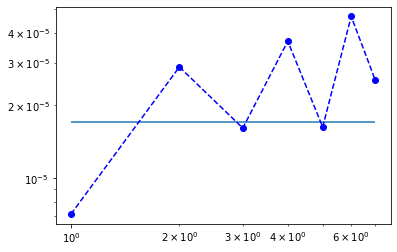

In [165]:
process_file(1)

In [187]:
def process_file_2(file_index):
    tau = [k for k in range(1, 10)]
    print('Processing file #{0}...'.format(file_index))
    with open('data/{0}.txt'.format(file_index), 'r') as file:
        X_train, y_train, X_test, y_test = read_dataset(file)
        zero_error = process_dataset(X_train, y_train, X_test, y_test, get_svd_model, 0)
        method_error = []
        for t in tau:
            cur_error = process_dataset(X_train, y_train, X_test, y_test, get_svd_model, t)
            method_error.append(cur_error)
        plt.plot(tau, method_error, linestyle='--', marker='o', color='b')
        plt.hlines(zero_error, tau[0], tau[-1])
        plt.show()

Processing file #1...


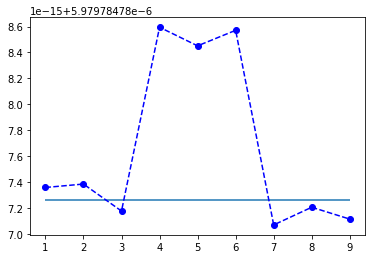

In [188]:
process_file_2(1)